# Exercise 6 – Linking Opportunity Index & ACE Proxy

In this exercise, you will examine how community opportunity factors relate to a proxy measure of **Adverse Childhood Experiences (ACEs)** using census tracts in New Jersey.

**Key Variables:**
*   **SDH Indicators:** Census tract level z-scores for specific Social Determinants of Health (SDH).
*   **ACE Proxy:** A county-level variable (child welfare cases per 1,000 children) that is repeated for all tracts within a county.

**What you will produce:**
1.  A **choropleth map** of your assigned SDH variable (`CASE_VAR_Z`) at the tract level. A **choropleth map** is a thematic map where each geographic area is shaded according to a data value. 
2.  **Correlation (r) and scatterplot** of your SDH variable vs. the ACE proxy (`cw_cases_per_1000_Z`).
3.  **Correlations (r) and scatterplots** of two mini-indices (Education and Social/Economic) vs. the ACE proxy.
4.  **Correlation (r) and scatterplot** of the overall composite (`COI_mini`) vs. the ACE proxy.

**Note:** When you interpret these correlations in your slides, remember that SDH variables are tract-level while the ACE proxy is county-level. These are cross-level correlations and do not show individual-level causation.

In [15]:
# Working in Codespaces? Skip this cell.
# Working in VS Code Jupyter notebook? Uncomment and run the following lines if you need to install these packages.

%pip install "mapclassify>=2.4.0"
%pip install folium

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import folium
import numpy as np

# Configuration: edit ONLY CASE_VAR and optionally GROUP_ID

GROUP_ID = "G07"  # Group identifier used in filenames

# Allowed SDH variables for this exercise:
# DO NOT EDIT SDH_OPTIONS
SDH_OPTIONS = ["ED_ECENROL", "ED_HSGRAD", "ED_MATH", "HE_GREEN", "SE_EMPRAT"]

# TO DO: set your assigned variable from the list above
CASE_VAR = "____"  # <--- ENTER YOUR ASSIGNED VARIABLE


# Guard: require CASE_VAR to be set to a valid option
if CASE_VAR == "____" or CASE_VAR.strip() == "":
    raise ValueError(
        "⚠️ Please set CASE_VAR to one of: "
        + ", ".join(SDH_OPTIONS)
        + " before continuing."
    )
if CASE_VAR not in SDH_OPTIONS:
    raise ValueError(
        f"⚠️ CASE_VAR must be one of: {', '.join(SDH_OPTIONS)}. "
        f"You entered: {CASE_VAR}"
    )

EXPORT_DIR = "figs_ex6_" + GROUP_ID  # Directory for saving figures
MAP_QUANTILES = 5  # Number of quantile classes for choropleth
SEED = 4242  # Random seed for reproducibility

## Load Data & Quality Checks

We load the GeoJSON file containing New Jersey census tracts along with the COI indicators and ACE proxy. It’s important to verify that the data are well‑formed before analysis:

- **CRS check:** ensure the coordinate reference system is WGS 84 (EPSG: 4326).  
- **Unique identifiers:** each census tract is identified by its `GEOID`. Confirm that there are no duplicates.  
- **County broadcast check:** fields derived from the child welfare data (`cw_cases_count`, `cw_cases_per_1000`) should be constant for all tracts within the same county.  
- **Missing values:** identify and drop tracts with missing values in any of the variables you will analyse.  
- **Zero population:** drop any tracts with zero children under 18 so the ACE proxy isn’t undefined.

Run the cell below to load the data and perform these checks. It will also print how many tracts are dropped due to missing data or zero population.


In [17]:
# Load the merged GeoJSON data
# Make sure this file exists in the working directory or adjust the path accordingly
gdf = gpd.read_file("data/merged_data_plus_aceproxy_rate.geojson")

# ACE proxy (cw_cases_per_1000) is county-level and the same value is repeated for all tracts in a county.

# Check coordinate system
if gdf.crs is not None:
    try:
        epsg = gdf.crs.to_epsg()
        if epsg != 4326:
            print("Warning: Data is not in EPSG:4326.")
    except Exception as e:
        print("CRS check skipped.")

# Drop tracts with no children (under18_pop <= 0)
if "under18_pop" in gdf.columns:
    gdf = gdf[gdf["under18_pop"] > 0].copy()

# Drop rows with missing values in variables of interest
# We check SDH_OPTIONS and the ACE proxy
key_vars = SDH_OPTIONS + ["cw_cases_per_1000"]
gdf = gdf.dropna(subset=[var for var in key_vars if var in gdf.columns])

print("Number of tracts:", len(gdf))
print("Unique counties:", gdf["county_fips"].nunique())

Number of tracts: 1679
Unique counties: 21


## Standardizing Variables

To compare indicators measured on different scales, convert each to a z‑score: subtract the mean and divide by the standard deviation across all NJ tracts. The helper function `zify()` adds a `_<var>_Z` column to the GeoDataFrame if it doesn’t already exist. Missing values remain `NaN` so they don’t influence the mean or standard deviation.


In [18]:
def zify(series):
    return (series - series.mean()) / series.std()

### Standardize Variables & Build Mini‑COI

Run the next cell to create z‑score versions of all COI indicators listed in `ED_VARS` and `SE_VARS`, as well as the ACE proxy rate. Then compute two simple composite indices:

- `COI_edu_mini` – the mean of the education z‑scores (`ED_ECENROL_Z`, `ED_HSGRAD_Z`, `ED_MATH_Z`).
- `COI_SE_mini` – the mean of the social/economic z‑scores (`HE_GREEN_Z` and `SE_EMPRAT_Z`).

These "mini COI" measures approximate the official COI domain scores by equally weighting each standardized indicator within their respective domains. We also save a small JSON file documenting exactly which z‑score columns were averaged in each composite for reproducibility.

In [19]:
# Compute z-scores for all SDH variables
for var in SDH_OPTIONS:
    if var in gdf.columns:
        gdf[f"{var}_Z"] = zify(gdf[var])

# Compute ACE proxy z-score
if "cw_cases_per_1000" in gdf.columns:
    gdf["cw_cases_per_1000_Z"] = zify(gdf["cw_cases_per_1000"])

# Compute mini COI composites
EDU_COMPONENTS = ["ED_ECENROL_Z", "ED_HSGRAD_Z", "ED_MATH_Z"]
SE_COMPONENTS = ["HE_GREEN_Z", "SE_EMPRAT_Z"]
OVERALL_COMPONENTS = EDU_COMPONENTS + SE_COMPONENTS

gdf["COI_edu_mini"] = gdf[EDU_COMPONENTS].mean(axis=1)
gdf["COI_SE_mini"] = gdf[SE_COMPONENTS].mean(axis=1)
gdf["COI_mini"] = gdf[OVERALL_COMPONENTS].mean(axis=1)

print("COI_edu_mini components:", EDU_COMPONENTS)
print("COI_SE_mini components:", SE_COMPONENTS)
print("COI_mini components:", OVERALL_COMPONENTS)
print("All minis are simple averages of their component z-scores.")

# Instructor-use only; students do not need this file for Exercise 6.
mini_coi_recipe = {
    "COI_edu_mini": EDU_COMPONENTS,
    "COI_SE_mini": SE_COMPONENTS,
    "COI_mini": OVERALL_COMPONENTS,
    "note": "All components are oriented so higher = better before averaging."
}
os.makedirs(EXPORT_DIR, exist_ok=True)
import json
with open(os.path.join(EXPORT_DIR, f"{GROUP_ID}_mini_coi_recipe.json"), "w") as f:
    json.dump(mini_coi_recipe, f, indent=2)

COI_edu_mini components: ['ED_ECENROL_Z', 'ED_HSGRAD_Z', 'ED_MATH_Z']
COI_SE_mini components: ['HE_GREEN_Z', 'SE_EMPRAT_Z']
COI_mini components: ['ED_ECENROL_Z', 'ED_HSGRAD_Z', 'ED_MATH_Z', 'HE_GREEN_Z', 'SE_EMPRAT_Z']
All minis are simple averages of their component z-scores.


## Choropleth Map

Run this cell, then hover on the map and intentionally pick one census tract to use in your slide table. Choose a tract that looks clearly high or low based on color. Record its GEOID, County FIPS, and <CASE_VAR>_Z from the popup.

In [ ]:
# GENERATE MAP

# Ensure export dir exists
os.makedirs(EXPORT_DIR, exist_ok=True)

gdf_map = gdf.copy()
gdf_map["geometry"] = gdf_map.geometry.simplify(tolerance=0.001, preserve_topology=True)

def interactive_choropleth(column, title, html_filename, fill_color="Blues", legend_title="z-score (SD) [higher = better]"):
    m = folium.Map(location=[40.06, -74.4], zoom_start=8, tiles="cartodbpositron")

    bins = list(np.nanquantile(gdf_map[column], np.linspace(0, 1, MAP_QUANTILES + 1)))

    folium.Choropleth(
        geo_data=gdf_map.to_json(),
        data=gdf_map,
        columns=["GEOID", column],
        key_on="feature.properties.GEOID",
        fill_color=fill_color,
        fill_opacity=0.7,
        line_opacity=0.2,
        bins=bins,
        legend_name=legend_title,
        name=title
    ).add_to(m)

    # Lighter tooltip only (no extra GeoJson layer)
    folium.GeoJson(
        gdf_map,
        style_function=lambda feature: {'fillColor': 'transparent', 'color': 'transparent', 'weight': 0},
        tooltip=folium.GeoJsonTooltip(
            fields=["GEOID", "county_fips", f"{CASE_VAR}_Z"],
            aliases=["GEOID:", "County FIPS:", f"{CASE_VAR}_Z:"],
            localize=True
        )
    ).add_to(m)

    out_path = os.path.join(EXPORT_DIR, html_filename)
    m.save(out_path)
    return m


# Generate map for CASE_VAR
m_case = interactive_choropleth(
    column=f"{CASE_VAR}_Z",
    title=f"{CASE_VAR} (Z-score)",
    html_filename=f"{GROUP_ID}_{CASE_VAR}_Z_map.html"
)
m_case

# GIVE THIS 3-5 MINUTES TO LOAD IN THE NOTEBOOK VIEWER


## ✅ Complete Table 2 

Use these short primers to answer the COI “composition & calculation” questions in Table 2.
These summarize how the **official Child Opportunity Index (COI) 2.0** builds its domain composites.  
Our classroom mini-COIs are simplified teaching versions—use these notes for comparison.

#### COI 2.0 in one paragraph
COI 2.0 measures child-relevant neighborhood opportunity using **29 indicators** grouped into **three domains**—**Education**, **Health & Environment**, and **Social & Economic**—for all U.S. census tracts.  
Each indicator is **z-scored** (2010 baseline) and direction-aligned so that higher = more opportunity.  
Indicators are then **weighted** (not equally) based on their average association with independent health and economic outcomes.  
Weighted indicators form domain scores; the overall COI aggregates those domains with the same evidence-based weighting.  
Child Opportunity Levels (Very Low → Very High) correspond to percentile groups of these standardized domain / overall scores.

#### Education Domain – What it Measures & How it’s Combined
- **Indicators:** early-childhood education access & enrollment, 3rd-grade reading and math proficiency, on-time high-school graduation, AP course participation, nearby college enrollment, school poverty (reversed), teacher experience (reversed), and adult educational attainment.  
- **Computation:** each indicator → z-score (2010), direction reversed where needed, then assigned a data-driven weight according to its predictive strength; weighted indicators sum to the Education domain score.  
- **Our mini version:**  
  `COI_edu_mini = mean(ED_ECENROL_Z, ED_HSGRAD_Z, ED_MATH_Z)` (equal weights; higher = better).

#### Social & Economic Domain – What it Measures & How it’s Combined
- **Indicators:** economic resources and family structure factors—employment rate, long commute share (reversed), single-parent household share (reversed), plus an **Economic Resource Index** combining poverty, public assistance, homeownership, high-skill employment, and median household income via principal components analysis (PCA).  
- **Computation:** z-score each indicator, align direction, apply empirical weights from predictive models, and sum to the Social & Economic domain score.  
- **Our mini COI version**
  `COI_SE_mini = mean(HE_GREEN_Z, SE_EMPRAT_Z)` (equal weights; higher = better).  
  *Note:* The official Social & Economic domain includes more socioeconomic measures (poverty, income, housing, family structure) and weighted aggregation for greater validity.
---

### Learn more (official source)
**Child Opportunity Index 2.0 – Technical Documentation** (education & social/economic indicator lists, standardization, PCA economic resource index, weighting and aggregation details):  
https://www.diversitydatakids.org/sites/default/files/2020-02/ddk_coi2.0_technical_documentation_20200212.pdf

*Footnote:* `COI_edu_mini` = mean(ED_ECENROL_Z, ED_HSGRAD_Z, ED_MATH_Z); `COI_SE_mini` = mean(HE_GREEN_Z, SE_EMPRAT_Z). Higher = better.


## Correlations and Scatterplots

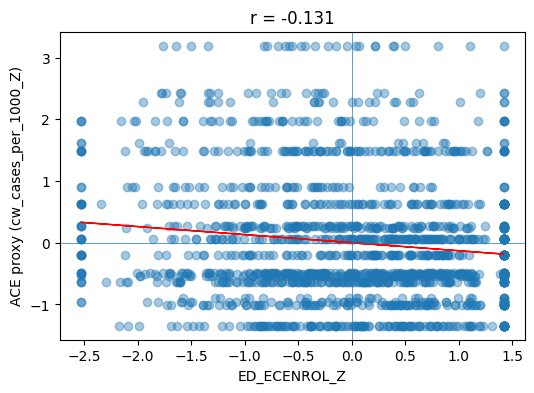

Correlation r(ED_ECENROL_Z, ACE proxy (cw_cases_per_1000_Z)) = -0.131


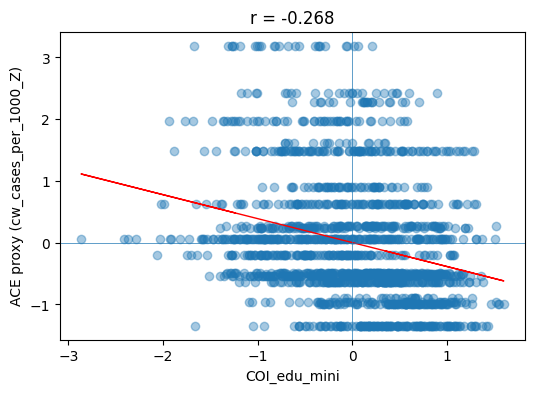

Correlation r(COI_edu_mini, ACE proxy (cw_cases_per_1000_Z)) = -0.268


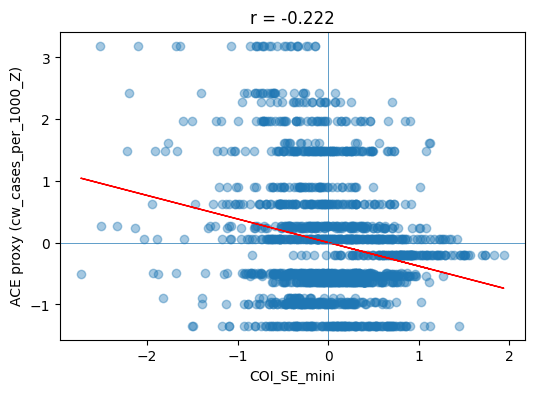

Correlation r(COI_SE_mini, ACE proxy (cw_cases_per_1000_Z)) = -0.222


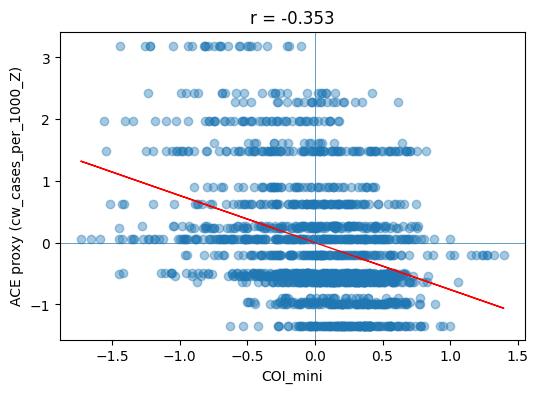

Correlation r(COI_mini, ACE proxy (cw_cases_per_1000_Z)) = -0.353


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_with_r(x, y, x_label, y_label):
    valid = ~(x.isna() | y.isna())
    x_clean = x[valid]
    y_clean = y[valid]

    r = np.corrcoef(x_clean, y_clean)[0, 1]

    # Calculate trendline (1st degree polynomial)
    m, b = np.polyfit(x_clean, y_clean, 1)

    plt.figure(figsize=(6, 4))
    plt.scatter(x_clean, y_clean, alpha=0.4)
    
    # Plot trendline
    plt.plot(x_clean, m*x_clean + b, color="red", linewidth=1)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"r = {r:.3f}")
    plt.axhline(0, linewidth=0.5)
    plt.axvline(0, linewidth=0.5)
    plt.show()

    print(f"Correlation r({x_label}, {y_label}) = {r:.3f}")
    return r

# 1. CASE_VAR vs ACE Proxy
r_case = scatter_with_r(
    gdf[f"{CASE_VAR}_Z"],
    gdf["cw_cases_per_1000_Z"],
    f"{CASE_VAR}_Z",
    "ACE proxy (cw_cases_per_1000_Z)"
)

# 2. COI_edu_mini vs ACE Proxy
r_coi_edu = scatter_with_r(
    gdf["COI_edu_mini"],
    gdf["cw_cases_per_1000_Z"],
    "COI_edu_mini",
    "ACE proxy (cw_cases_per_1000_Z)"
)

# 3. COI_SE_mini vs ACE Proxy
r_coi_se = scatter_with_r(
    gdf["COI_SE_mini"],
    gdf["cw_cases_per_1000_Z"],
    "COI_SE_mini",
    "ACE proxy (cw_cases_per_1000_Z)"
)

# 4. COI_mini (Overall) vs ACE Proxy
r_coi_overall = scatter_with_r(
    gdf["COI_mini"],
    gdf["cw_cases_per_1000_Z"],
    "COI_mini",
    "ACE proxy (cw_cases_per_1000_Z)"
)

## Next Steps

Carry the following into your individual deliverable slides:

*   **From the map:**
    *   GEOID and County FIPS of your chosen tract.
    *   `<CASE_VAR>_Z` for that tract (for the z-score explanation).
*   **From the scatterplots:**
    *   `r_case` for your SDH variable vs ACE proxy.
    *   `r_coi_edu`, `r_coi_se`, and `r_coi_overall` for the COI minis and COI_mini vs ACE proxy (these go in the group table).
*   **From the composite definitions printed earlier:**
    *   The component lists and "average of z-scores" description for "mini vs official" bullets.

**Remember:** When you interpret these correlations in your slides, remember that SDH variables are tract-level while the ACE proxy is county-level. These are cross-level correlations and do not show individual-level causation.


**Data sources**

- **Child Opportunity Index (COI) 2.0** – tract‑level indicators that measure educational, environmental and socio‑economic opportunities for children. The raw indicators we will use (all oriented so higher values mean better opportunity) are:
  - `ED_ECENROL` – early childhood (age 3–4) enrollment rate.
  - `ED_HSGRAD` – high school on‑time graduation rate.
  - `ED_MATH` – third‑grade math proficiency (NAEP scale).
  - `HE_GREEN` – greenspace/park access index (treated here as a community factor).
  - `SE_EMPRAT` – employment rate among working‑age adults.

Data Source: diversitydatakids.org. (2020). Child Opportunity Index 2.0 census tract data. Brandeis University, The Heller School for Social Policy and Management. Retrieved from https://www.diversitydatakids.org/research-library/child-opportunity-index-20-census-tract-data 

- **Child welfare ACE proxy** – county‑level counts of child welfare cases (`cw_cases_count`) and under‑18 population (`under18_pop`) from the NJ Child Welfare Data Hub and the ACS. We derive `cw_cases_per_1000` (cases per 1 000 children) and its z‑score `cw_cases_per_1000_Z`. This serves as a proxy for ACE prevalence. **Important:** this value is identical for all tracts in a county, so any correlation with tract‑level indicators is driven by differences *between counties* rather than within them.

Data source: New Jersey State Policy Lab. (n.d.). Child abuse and neglect dashboard. Rutgers University. Retrieved from https://njchilddata.rutgers.edu/portal/child-abuse-neglect

The dataset `exercises/E06_coi_mapping/data/merged_data_plus_aceproxy_rate.geojson` already merges these sources and includes 2010 tract geometries. Before mapping and analysis we will:
